In [145]:
'''
    steps
'''
import pandas as pd
import pyBigWig
import pybedtools
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings('ignore')

In [2]:
from matplotlib import rcParams 
rcParams['pdf.fonttype'] = 42 # True font
rcParams['font.family'] =  "sans-serif" 
rcParams['font.sans-serif'] = "Liberation Sans"  # font Arial
rcParams['font.size'] =  8  
rcParams['grid.linewidth'] =  0.5 
rcParams['lines.color'] = 'b' 
rcParams['lines.linewidth'] = 1 
rcParams['lines.markersize'] = 3
rcParams['lines.markeredgewidth'] = 0 # set Marker with no edgelines
rcParams['axes.linewidth'] = 0.5
rcParams['axes.titlesize'] = 8
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8
rcParams['legend.fontsize'] = 8
rcParams['legend.title_fontsize'] = 8

In [148]:
# 50kb bins dataframe
chromsizes = "/data1/ZJY/Pore-C/Analysis/hg38.chromosomes.size" # genome chrom sizes file
binsize = 50000 #50kb
bins = pybedtools.BedTool().window_maker(w=binsize, g=chromsizes)
bins_df = bins.to_dataframe()
bins_df = bins_df.loc[(bins_df.chrom != "chrX")&(bins_df.chrom != "chrY"), :] 
bins_df["ID"] = bins_df.index.values
bins_df

,chrom,start,end,ID
0,chr1,0,50000,0
1,chr1,50000,100000,1
2,chr1,100000,150000,2
3,chr1,150000,200000,3
4,chr1,200000,250000,4
...,...,...,...,...
57504,chr22,50600000,50650000,57504
57505,chr22,50650000,50700000,57505
57506,chr22,50700000,50750000,57506
57507,chr22,50750000,50800000,57507


In [142]:
# laoding data
Datadir = "/data1/ZJY/GpC/Analysis/Jupyter/Figures/Subcompartments"
bedfile = f"{Datadir}/GM_1_22_50kb_all_sub_compartments.bed"

def LoadingSubcompartment(bedfile):
    subcomp_df = pd.read_csv(bedfile, header=None, index_col=None, 
                             sep="\t", names=["chrom", "start", "end", "subcompartment", "subvalue", "color"],
                             usecols = [0,1,2,3,4,8])
    ## Comparment Rank
    subcoms = list( subcomp_df.subcompartment.unique() )
    subcoms = sorted (subcoms)
    subval = dict()
    for n in range(0, len(subcoms)):
        subval[ subcoms[n] ] = n 
    subcomp_df["Ranks"] = subcomp_df["subcompartment"].apply(lambda x: subval[x])
    subcomp_df["SubComp"] = subcomp_df["subcompartment"].str[:5]

    ## 8 subcompartment ID 
    subcoms = list( subcomp_df.SubComp.unique() )
    subcoms = sorted (subcoms)
    subval = dict()
    for n in range(0, len(subcoms)):
        subval[ subcoms[n] ] = n + 1
    subcomp_df["SubComp_ID"] = subcomp_df["SubComp"].apply(lambda x: subval[x])
    return(subcomp_df)

subcomp_df = LoadingSubcompartment(bedfile)

In [143]:
subcomp_df.head()

,chrom,start,end,subcompartment,subvalue,color,Ranks,SubComp,SubComp_ID
0,chr1,100001,150000,A.2.2.1.2.2.2.1,0.625,#FFDADA,1274,A.2.2,4
1,chr1,350001,500000,A.2.2.1.2.2.2.1,0.625,#FFDADA,1274,A.2.2,4
2,chr1,600001,750000,A.2.2.1.2.2.2.1,0.625,#FFDADA,1274,A.2.2,4
3,chr1,750001,1000000,A.2.1.2.1.1.2.2.2,0.750,#FF9191,1049,A.2.1,3
4,chr1,1000001,1150000,A.1.2.1.2.2.1.1.2,0.875,#FF4848,607,A.1.2,2


In [204]:
## bigwig file
bigdir = "/data1/ZJY/GpC/Analysis/CpGGpC"
CpG_bw = pyBigWig.open(f"{bigdir}/GM12878_Integrated_CpG.bigWig") # Open bigWig file
GpC_bw = pyBigWig.open(f"{bigdir}/GM12878_Integrated_GpC.bigWig") # Open bigWig file

k562_CpG_bw = pyBigWig.open(f"{bigdir}/K562_Integrated_CpG.bigWig") # Open bigWig file
k562_GpC_bw = pyBigWig.open(f"{bigdir}/K562_Integrated_GpC.bigWig") # Open bigWig file

In [58]:
def Bwmean(regions, bw):
    '''
    get mean values for regions from a bigwig file
    '''
    means = []
    chrom_lengths =  bw.chroms()
    for i, r in regions.iterrows() :
        chrom, start, end = r["chrom"], r["start"], r["end"]
        if end >= chrom_lengths[chrom]:
            end = chrom_lengths[chrom]
        mv = bw.stats(chrom, start, end, 'mean')[0]
        means.append(mv)
    return(means)

In [59]:
# Correlation between compartment rank and gpc, cpg
regions = subcomp_df.loc[:, ["chrom", "start", "end"]]
subcomp_df["GpC"] = Bwmean(regions, GpC_bw)
subcomp_df["CpG"] = Bwmean(regions, CpG_bw)

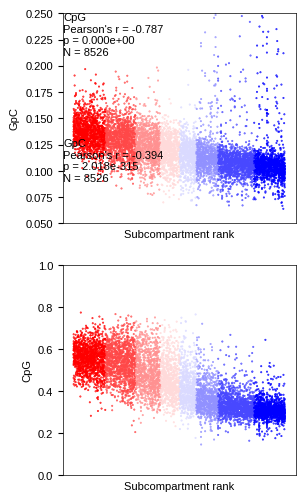

In [132]:
# GpC
from matplotlib.colors import Normalize
from scipy.stats import pearsonr


fig, axs = plt.subplots(2,1, figsize=(3,6))

ykey = "GpC"
df = pd.DataFrame({"x": subcomp_df.loc[:, "Ranks"].values,
                  "y": subcomp_df.loc[:, ykey ].values,
                  "colors":subcomp_df.loc[:, "color" ].values} )
axs[0].scatter(df['x'], df['y'], c=df['colors'], s=0.2).set_rasterized(True)
axs[0].set_rasterization_zorder(1)
corr, p = pearsonr(df['x'], df['y'])
axs[0].text(0, 0.20, 
         f"{ykey}\nPearson's r = {corr:.3f}\np = {p:.3e}\nN = {len(df)}",
         transform=axs[0].transAxes, zorder=2)
axs[0].set_xticks([])
axs[0].set_ylim([0.05, 0.25])
axs[0].set(xlabel='Subcompartment rank', ylabel=ykey)

ykey = "CpG"
df = pd.DataFrame({"x": subcomp_df.loc[:, "Ranks"].values,
                  "y": subcomp_df.loc[:, ykey ].values,
                  "colors":subcomp_df.loc[:, "color" ].values} )
axs[1].scatter(df['x'], df['y'], c=df['colors'], s=0.2).set_rasterized(True)
axs[1].set_rasterization_zorder(1)
corr, p = pearsonr(df['x'], df['y'])
axs[1].text(0, 0.8, 
         f"{ykey}\nPearson's r = {corr:.3f}\np = {p:.3e}\nN = {len(df)}",
         transform=axs[0].transAxes, zorder=2)
axs[1].set_xticks([])
axs[1].set_ylim([0.0, 1.0])
axs[1].set(xlabel='Subcompartment rank', ylabel=ykey)


plt.show()